# Project Objectives and Scope:

- **Objective:** Develop an image processing system to detect discoloration in food products, specifically targeting fruits and vegetables, to identify signs of spoilage or contamination.

- **Scope:** The project will involve capturing images of various fruits and vegetables samples, processing these images to detect color anomalies, and then classifying the fruits and vegetables as either good or potentially spoiled/contaminated.

# Image Classification of Fruits and Vegetables: Fresh vs. Rotten

## Step 1: Define the Problem
The goal is to classify images of fruits and vegetables into two categories: **fresh** and **rotten**. This classification can significantly assist in automating the process of quality control within the food industry.

## Step 2: Gather and Prepare the Data

- **The Dataset used:** Fresh and Rotten Classification from Kaggle

[Fresh and Rotten Classification | Kaggle](https://www.kaggle.com/datasets/swoyam2609/fresh-and-stale-classification/data)

## Step 3: Preprocess the Data

Preprocessing data is a crucial step in any machine learning workflow, especially in image processing tasks. It involves preparing raw data to make it suitable for a machine learning model, which helps improve the performance of the model. For your project on classifying images of fruits as either fresh or rotten, here are the main preprocessing tasks you should consider:

### 1. Standardizing Folder Structure
To simplify data handling and make your dataset easy to manage, it's a good idea to standardize the naming convention and structure of your dataset folders. This involves:
- Renaming folders to have consistent naming across different types of fruits.
- Possibly reorganizing images to ensure all "fresh" and "rotten" categories are uniformly named.

### 2. Image Resizing
- Since neural networks require input data to be of the same size, images in your dataset should be resized to a fixed dimension. This ensures consistency in how features are learned across different images.

### 3. Normalization
- Image normalization adjusts the range of pixel intensity values to a common scale, typically 0 to 1. This is performed by dividing each pixel value by 255. Normalization helps maintain numerical stability and speeds up the convergence during training.


### 4. Color Space Conversion
- Depending on your model's requirements or the characteristics of the data, converting images from one color space to another (e.g., RGB to HSV or grayscale) might be beneficial, especially if certain features are more pronounced in specific color spaces.

### 5. Creating Data Loaders
- Once images are processed, they need to be batched, shuffled, and prepared for training. Data loaders facilitate the handling of large datasets by loading small batches of data on-the-fly during training.

In [1]:
!kaggle datasets download -d swoyam2609/fresh-and-stale-classification

Dataset URL: https://www.kaggle.com/datasets/swoyam2609/fresh-and-stale-classification
License(s): Community Data License Agreement - Permissive - Version 1.0
100% 2.84G/2.84G [00:31<00:00, 96.0MB/s]
100% 2.84G/2.84G [00:31<00:00, 95.6MB/s]


In [ ]:
!unzip "/content/fresh-and-stale-classification.zip" -d "/content"


### Step 4: Image Processing Techniques

- **Color Space Conversion**: Convert your images to a color space conducive to identifying discolorations effectively, such as HSV or LAB.
- **Color Thresholding**: Apply color thresholding to isolate areas of interest in the image that indicate potential spoilage or contamination.
- **Feature Extraction**: Extract relevant features from the images that could be useful for classification. This might include statistical color features, texture features, or shape features.

In [3]:
import os
import cv2
import numpy as np

def convert_color_space(image, target_space):
    if target_space == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif target_space == 'LAB':
        return cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

def adjust_brightness_contrast(image, alpha=1.2, beta=25):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def create_color_mask(hsv_image, lower_bound, upper_bound):
    return cv2.inRange(hsv_image, lower_bound, upper_bound)

def apply_masks(image):
    image_hsv = convert_color_space(image, 'HSV')
    lower_red = np.array([0, 70, 50])
    upper_red = np.array([10, 255, 255])
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    lower_green = np.array([50, 100, 50])
    upper_green = np.array([70, 255, 255])

    red_mask = create_color_mask(image_hsv, lower_red, upper_red)
    yellow_mask = create_color_mask(image_hsv, lower_yellow, upper_yellow)
    green_mask = create_color_mask(image_hsv, lower_green, upper_green)
    combined_mask = cv2.bitwise_or(red_mask, yellow_mask)
    combined_mask = cv2.bitwise_or(combined_mask, green_mask)

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image_3channel = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    non_colored_regions = cv2.bitwise_and(gray_image_3channel, gray_image_3channel, mask=cv2.bitwise_not(combined_mask))
    final_image = cv2.add(non_colored_regions, cv2.bitwise_and(image, image, mask=combined_mask))
    return final_image

def process_directory_recursive(input_directory, output_directory, apply_masks_folders):
    for entry in os.listdir(input_directory):
        full_input_path = os.path.join(input_directory, entry)
        full_output_path = os.path.join(output_directory, entry)

        if os.path.isdir(full_input_path):
            if entry in apply_masks_folders:
                for file in os.listdir(full_input_path):
                    if file.lower().endswith((".png", ".jpg", ".jpeg")):
                        file_path = os.path.join(full_input_path, file)
                        image = cv2.imread(file_path)
                        if image is not None:
                            final_image = apply_masks(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                            cv2.imwrite(file_path, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
            else:
                process_directory_recursive(full_input_path, full_output_path, apply_masks_folders)
        elif entry.lower().endswith((".png", ".jpg", ".jpeg")):
            image = cv2.imread(full_input_path)
            if image is not None:
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image_adjusted = adjust_brightness_contrast(image_rgb, alpha=1.2, beta=25)
                image_hsv = convert_color_space(image_adjusted, 'HSV')
                cv2.imwrite(full_input_path, cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR))

directory_to_process = 'dataset/Test'
apply_masks_folders = {'freshapples', 'freshbanana', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottentomato'}

process_directory_recursive(directory_to_process, directory_to_process, apply_masks_folders)


KeyboardInterrupt: 

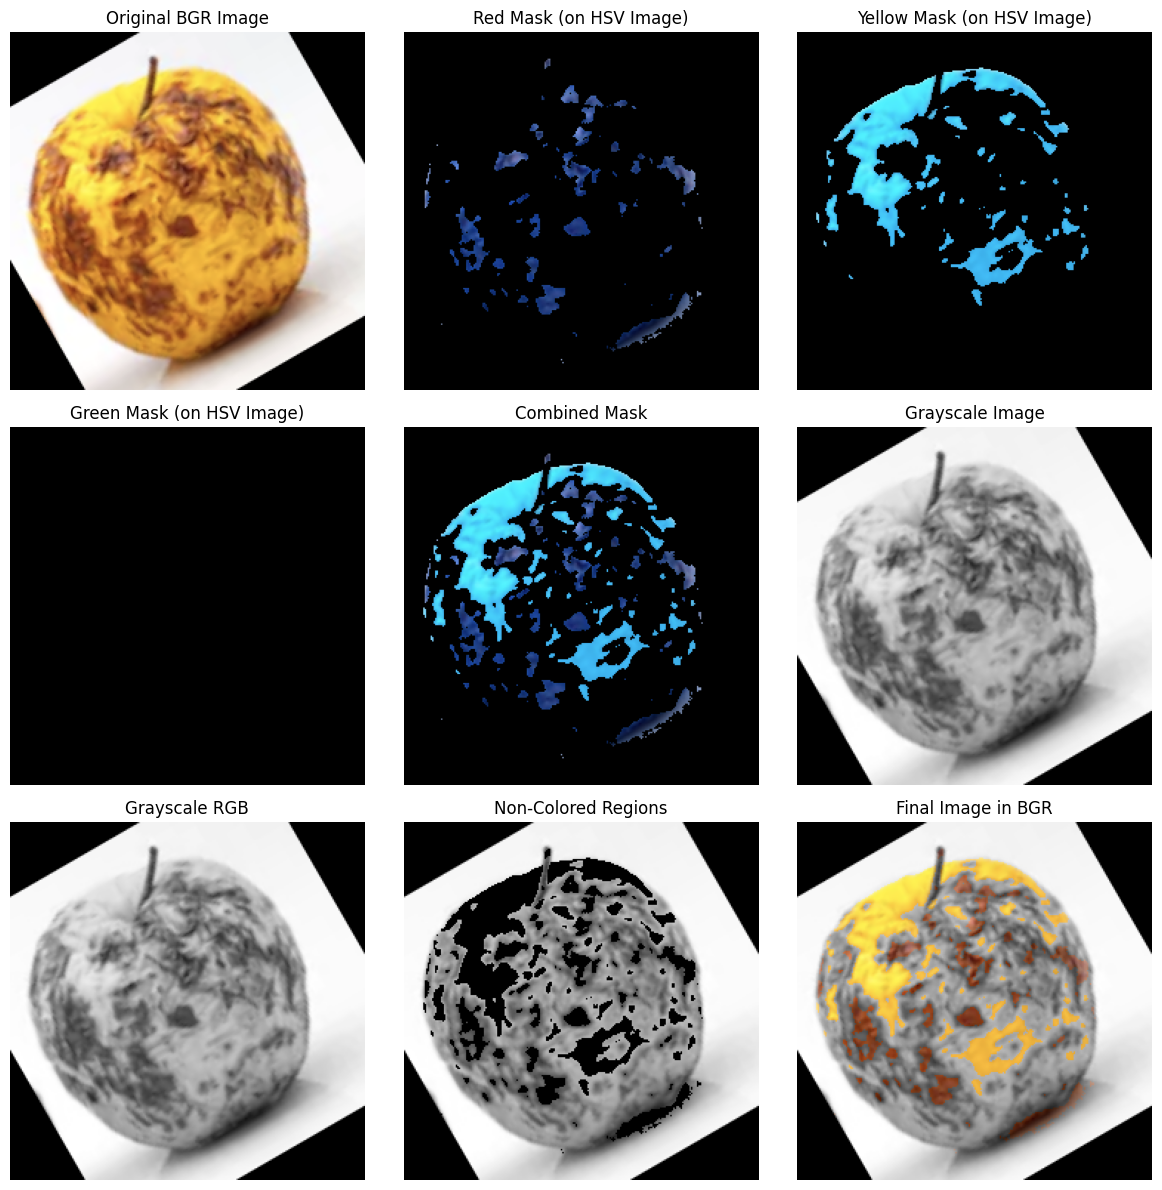

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def convert_color_space(image, target_space):
    if target_space == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

def create_color_mask(hsv_image, lower_bound, upper_bound):
    return cv2.inRange(hsv_image, lower_bound, upper_bound)

def apply_mask(original_rgb, mask):
    colored_mask = cv2.bitwise_and(original_rgb, original_rgb, mask=mask)
    return colored_mask

def process_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_hsv = convert_color_space(image_rgb, 'HSV')

    lower_red = np.array([0, 70, 50])
    upper_red = np.array([10, 255, 255])
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    lower_green = np.array([50, 100, 50])
    upper_green = np.array([70, 255, 255])
    red_mask = create_color_mask(image_hsv, lower_red, upper_red)
    yellow_mask = create_color_mask(image_hsv, lower_yellow, upper_yellow)
    green_mask = create_color_mask(image_hsv, lower_green, upper_green)
    combined_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask, yellow_mask), green_mask)

    gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    gray_image_3channel = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    non_colored_regions = cv2.bitwise_and(gray_image_3channel, gray_image_3channel, mask=cv2.bitwise_not(combined_mask))
    final_image = cv2.add(non_colored_regions, apply_mask(image_rgb, combined_mask))

    fig, ax = plt.subplots(3, 3, figsize=(12, 12))
    ax = ax.flatten()

    titles = ['Original BGR Image', 'Red Mask (on HSV Image)', 'Yellow Mask (on HSV Image)', 'Green Mask (on HSV Image)',
              'Combined Mask', 'Grayscale Image', 'Grayscale RGB', 'Non-Colored Regions', 'Final Image in BGR']

    images = [image, apply_mask(image_rgb, red_mask), apply_mask(image_rgb, yellow_mask),
              apply_mask(image_rgb, green_mask), apply_mask(image_rgb, combined_mask),
              cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR), gray_image_3channel,
              non_colored_regions, final_image]  

    for i, img in enumerate(images):
        if i == 8:  
            ax[i].imshow(img)  
        else:
            ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
        ax[i].set_title(titles[i])
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

input_image_path = '/content/dataset/Train/rottenapples/a_r115.png'
process_image(input_image_path)


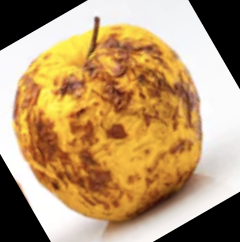

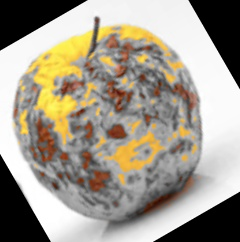

In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
def convert_color_space(image, target_space):
    if target_space == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif target_space == 'LAB':
        return cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

def create_color_mask(hsv_image, lower_bound, upper_bound):
    return cv2.inRange(hsv_image, lower_bound, upper_bound)

def process_image(image_path, output_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_hsv = convert_color_space(image_rgb, 'HSV')

    lower_red = np.array([0, 70, 50])
    upper_red = np.array([10, 255, 255])
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    lower_green = np.array([50, 100, 50])
    upper_green = np.array([70, 255, 255])

    red_mask = create_color_mask(image_hsv, lower_red, upper_red)
    yellow_mask = create_color_mask(image_hsv, lower_yellow, upper_yellow)
    green_mask = create_color_mask(image_hsv, lower_green, upper_green)

    combined_mask = cv2.bitwise_or(red_mask, yellow_mask)
    combined_mask = cv2.bitwise_or(combined_mask, green_mask)
    gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    gray_image_3channel = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    non_colored_regions = cv2.bitwise_and(gray_image_3channel, gray_image_3channel, mask=cv2.bitwise_not(combined_mask))

    final_image = cv2.add(non_colored_regions, cv2.bitwise_and(image_rgb, image_rgb, mask=combined_mask))
    cv2.imwrite(output_path, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))


input_image_path = '/content/dataset/Train/rottenapples/a_r115.png'
output_image_path = 'save.jpg'

process_image(input_image_path, output_image_path)
original_image=cv2.imread('/content/dataset/Train/rottenapples/a_r115.png')
cv2_imshow(original_image)
image=cv2.imread('save.jpg')
cv2_imshow(image)

<ipython-input-6-6fc46e6330b4>:11: RuntimeWarning: invalid value encountered in sqrt
  gradient_magnitude = np.sqrt(sobelx*2 + sobely*2)


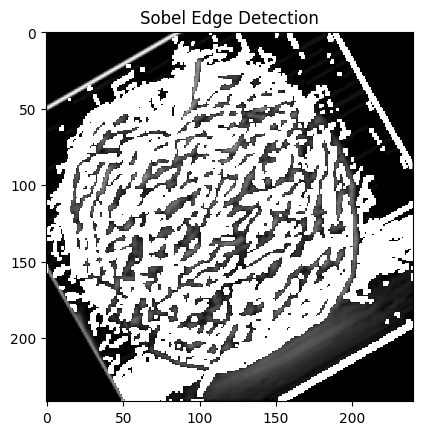

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
image = cv2.imread('/content/dataset/Train/rottenapples/a_r115.png', cv2.IMREAD_GRAYSCALE)

sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

gradient_magnitude = np.sqrt(sobelx*2 + sobely*2)

plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Sobel Edge Detection')
plt.show()

In [7]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

# Define a series of transformations to apply to the images.
transform= transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),# Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Load the dataset from a specified directory and apply the transformations.
full_dataset = datasets.ImageFolder('/content/dataset/Train', transform=transform)

# Calculate the sizes for training and testing datasets.
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Split the dataset into training and testing datasets.
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create data loaders to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Step 5: Develop a Model

- **Training and Testing Split**: Divide your dataset into training and testing sets. A common split is 80% for training and 20% for testing.
- **Model Selection**: Choose a model architecture suitable for your task. For a classification task, this could be a simple convolutional neural network (CNN) if you are using deep learning, or simpler classifiers like SVM if the task is less complex.
- **Model Training**: Train your model on the training dataset. Monitor performance metrics such as accuracy and loss.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) 
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)  
        self.fc2 = nn.Linear(1024, 18)          

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1)               
        x = F.relu(self.fc1(x))               
        x = self.dropout(x)                   
        x = self.fc2(x)                       
        return x

model = SimpleCNN()

print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=18, bias=True)
)


In [9]:
# In the provided code snippet, model.to(device) is used to move the model to the specified device (GPU or CPU).
import torch
from tqdm import tqdm  # tqdm is used to display progress bars

# Set up the device to use GPU if available, otherwise default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)  # Print the device being used

# Move the model to the specified device (GPU or CPU)
model.to(device)


Using device: cuda


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=18, bias=True)
)

In [10]:
import torch.optim as optim

# Define the loss function; CrossEntropyLoss is commonly used for classification tasks
criterion = nn.CrossEntropyLoss()

# Define the optimizer to update model parameters; Adam is a popular choice for its adaptive learning rate capabilities
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Set learning rate to 0.001


In [11]:
from tqdm import tqdm

num_epochs = 10  # Total number of epochs to train the model

# Iterate over the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode (enable dropout, batch normalization etc.)
    running_loss = 0.0  # Initialize the running loss for this epoch

    # Wrap the train_loader with tqdm for a progress bar that shows training progress per epoch
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")

    # Iterate over the training data
    for images, labels in train_loader_tqdm:

        # Move images and labels to the correct device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients to prevent accumulation from previous iterations
        optimizer.zero_grad()

        # Forward pass: Compute predicted outputs by passing images to the model
        outputs = model(images)

        # Calculate the loss between the predicted outputs and the true labels
        loss = criterion(outputs, labels)

        # Backward pass: compute the gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Accumulate the loss over the batch for reporting
        running_loss += loss.item()

        # Update the post-fix of the tqdm progress bar to show the average loss
        train_loader_tqdm.set_postfix(loss=running_loss/len(train_loader))
    model.eval()
    total = 0  
    correct = 0  
    with torch.no_grad():
        test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation")
        for images, labels in test_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loader_tqdm.set_postfix(accuracy=100.0 * correct / total)

    print(f"Accuracy after epoch {epoch+1}: {100 * correct / total}%")



Epoch 1/10 Training:  34%|███▍      | 203/591 [01:07<02:08,  3.02it/s, loss=0.571]


KeyboardInterrupt: 

### Step 6: Model Evaluation:
Evaluate the model on the testing set to see how well it generalizes to new data.

Print values

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
cm = confusion_matrix(true_labels, pred_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Measure:", f1)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

NameError: name 'model' is not defined

# Print the accuracy and loss for the current epoch

In [ ]:
model.eval()
total = 0
correct = 0
test_loss = 0

with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation")

    for images, labels in test_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loader_tqdm.set_postfix(accuracy=100.0 * correct / total)

        pred = outputs.argmax(dim=1, keepdim=True)
        test_loss += criterion(outputs, labels).item()
test_loss /= len(test_loader.dataset)
test_accuracy = 100. * correct / len(test_loader.dataset)

print(f"Accuracy after epoch {epoch+1}: {test_accuracy}%")
print(f"Test Loss: {test_loss}")

Epoch 4/50 Validation: 100%|██████████| 148/148 [00:47<00:00,  3.09it/s, accuracy=88.8]

Accuracy after epoch 4: 88.82303132938188%
Test Loss: 0.008698361092243126


augmentation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
true_labels = []
pred_labels = []
num_images_before_augmentation = 0
num_images_after_augmentation = 0

with torch.no_grad():
   
    for images, labels in test_loader:
       
        num_images_before_augmentation += images.size(0)

        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())
        num_images_after_augmentation += images.size(0)
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
cm = confusion_matrix(true_labels, pred_labels)

print("Number of images before augmentation:", num_images_before_augmentation)
print("Number of images after augmentation:", num_images_after_augmentation)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Measure:", f1)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

NameError: name 'model' is not defined

applied data augmentation methods using the
ImageDataGenerator() from Keras library and applay it to this code

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
data_generator = ImageDataGenerator(
    rotation_range=10,  # Rotate images randomly by up to 10 degrees
    width_shift_range=0.1,  # Randomly shift the width of images by up to 10%
    height_shift_range=0.1,  # Randomly shift the height of images by up to 10%
    shear_range=0.2,  # Apply shear transformations with a shear intensity of 0.2
    zoom_range=0.2,  # Zoom in or out on images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False  # Do not flip images vertically
)

In [ ]:
for images, labels in train_loader_tqdm:
    images, labels = images.to(device), labels.to(device)

    augmented_images = []
    for image in images:
        augmented_image = data_generator.random_transform(image)
        augmented_images.append(augmented_image)

    augmented_images = torch.stack(augmented_images)

    optimizer.zero_grad()
    outputs = model(augmented_images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    train_loader_tqdm.set_postfix(loss=running_loss / len(train_loader))